In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

# Correspondance Analysis

Resources:

* Correspondance Analysis
  * [Very comprehensive & good overview of interpretations](https://www.mathematica-journal.com/2010/09/20/an-introduction-to-correspondence-analysis/)
  * [Less comprehensive & more to the point](https://www.displayr.com/how-correspondence-analysis-works/)
  * [Fully devoted to interpreting the output plot](https://www.displayr.com/interpret-correspondence-analysis-plots-probably-isnt-way-think/)

* Multiple Correspondance Analysis
  * [Compare and contrast CA vs MCA](https://www.displayr.com/correspondence-analysis-versus-multiple-correspondence-analysis-use/)

In [41]:
import itertools

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

from scipy.spatial.distance import pdist, squareform

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [42]:
# try to import prince package, pip install if not found
try:
    import prince
except ModuleNotFoundError:
    !pip install prince
    import prince

<IPython.core.display.Javascript object>

In [43]:
def tall_dist(df, metric="euclidean"):
    """A tall/less redundant view of the distance matrix"""
    dists = pdist(df, metric)
    # index choose 2 generator
    combns = itertools.combinations(df.index, 2)
    rows = []
    for d, (a, b) in zip(dists, combns):
        row = {"a": a, "b": b, "dist": d}
        rows.append(row)

    return pd.DataFrame(rows)

<IPython.core.display.Javascript object>

In [44]:
# example:
df = pd.DataFrame({"x": [0, 3], "y": [0, 4]})

print("square distance matrix:")
display(pd.DataFrame(squareform(pdist(df))))

print(
    "\nA taller/less redundant view of the same square matrix:\n"
    "(diagonal is not here because we assume `dist(a, a)` = 0)"
)
display(tall_dist(df))

square distance matrix:


,0,1
0,0.0,5.0
1,5.0,0.0



A taller/less redundant view of the same square matrix:
(diagonal is not here because we assume `dist(a, a)` = 0)


,a,b,dist
0,0,1,5.0


<IPython.core.display.Javascript object>

#### Read in Data

In [45]:
# fmt: off
authors = ["Charles Darwin", "Rene Descartes",
           "Thomas Hobbes", "Mary Shelley", 
           "Mark Twain"]

chars = ["B", "C", "D", "F", 
         "G", "H", "I", "L", 
         "M", "N", "P", "R", 
         "S", "U", "W", "Y"]

long_names = ["Charles Darwin: 1", "Charles Darwin: 2", "Charles Darwin: 3",
              "Rene Descartes: 1", "Rene Descartes: 2", "Rene Descartes: 3",
              "Thomas Hobbes: 1", "Thomas Hobbes: 2", "Thomas Hobbes: 3", 
              "Mary Shelley: 1", "Mary Shelley: 2", "Mary Shelley: 3",
              "Mark Twain: 1", "Mark Twain: 2", "Mark Twain: 3"]

short_names = ["CD1", "CD2", "CD3",
               "RD1", "RD2", "RD3",
               "TB1", "TB2", "TB3",
               "MS1", "MS2", "MS3",
               "MT1", "MT2", "MT3"]

sample_crosstab = [[34, 37, 44, 27, 19, 39, 74, 44, 27, 61, 12, 65, 69,22, 14, 21],
                   [18, 33, 47, 24, 14, 38, 66, 41, 36,72, 15, 62, 63, 31, 12, 18],
                   [32, 43, 36, 12, 21, 51, 75, 33, 23, 60, 24, 68, 85,18, 13, 14],
                   [13, 31, 55, 29, 15, 62, 74, 43, 28,73, 8, 59, 54, 32, 19, 20],
                   [8, 28, 34, 24, 17, 68, 75, 34, 25, 70, 16, 56, 72,31, 14, 11], 
                   [9, 34, 43, 25, 18, 68, 84, 25, 32, 76,14, 69, 64, 27, 11, 18],
                   [15, 20, 28, 18, 19, 65, 82, 34, 29, 89, 11, 47, 74,18, 22, 17], 
                   [18, 14, 40, 25, 21, 60, 70, 15, 37,80, 15, 65, 68, 21, 25, 9],
                   [19, 18, 41, 26, 19, 58, 64, 18, 38, 78, 15, 65, 72,20, 20, 11], 
                   [13, 29, 49, 31, 16, 61, 73, 36, 29,69, 13, 63, 58, 18, 20, 25],
                   [17, 34, 43, 29, 14, 62, 64, 26, 26, 71, 26, 78, 64, 21, 18, 12],
                   [13, 22, 43, 16, 11, 70, 68, 46, 35,57, 30, 71, 57, 19, 22, 20],
                   [16, 18, 56, 13, 27, 67, 61, 43, 20, 63, 14, 43, 67,34, 41, 23], 
                   [15, 21, 66, 21, 19, 50, 62, 50, 24, 68, 14, 40, 58, 31, 36, 26],
                   [19, 17, 70, 12, 28, 53, 72, 39, 22, 71, 11, 40, 67,25, 41, 17]]
# fmt: on
crosstab = pd.DataFrame(sample_crosstab, columns=chars, index=long_names)

crosstab.index.name = "Author Sample"
crosstab.columns.name = "Character"

<IPython.core.display.Javascript object>

## Our Data

In [46]:
crosstab.style.background_gradient()

Character,B,C,D,F,G,H,I,L,M,N,P,R,S,U,W,Y
Author Sample,,,,,,,,,,,,,,,,
Charles Darwin: 1,34,37,44,27,19,39,74,44,27,61,12,65,69,22,14,21
Charles Darwin: 2,18,33,47,24,14,38,66,41,36,72,15,62,63,31,12,18
Charles Darwin: 3,32,43,36,12,21,51,75,33,23,60,24,68,85,18,13,14
Rene Descartes: 1,13,31,55,29,15,62,74,43,28,73,8,59,54,32,19,20
Rene Descartes: 2,8,28,34,24,17,68,75,34,25,70,16,56,72,31,14,11
Rene Descartes: 3,9,34,43,25,18,68,84,25,32,76,14,69,64,27,11,18
Thomas Hobbes: 1,15,20,28,18,19,65,82,34,29,89,11,47,74,18,22,17
Thomas Hobbes: 2,18,14,40,25,21,60,70,15,37,80,15,65,68,21,25,9
Thomas Hobbes: 3,19,18,41,26,19,58,64,18,38,78,15,65,72,20,20,11


<IPython.core.display.Javascript object>

In [8]:
crosstab.index = short_names
crosstab.index.name = "Author Sample"

<IPython.core.display.Javascript object>

## Custom EDA

Do some analysis, which of these author samples appear to be most similar? Which letters appear to be most similar?

Could try out measuring distances between rows/columns:

In [16]:
tall_dist(crosstab.T).sort_values(by="dist").head(5)

,a,b,dist
64,G,Y,26.343880
3,B,G,28.160256
63,G,W,31.622777
77,I,N,33.045423
9,B,P,33.926391


<IPython.core.display.Javascript object>

In [17]:
# Find the closest letters in terms of their usage by authors
letter_dists = tall_dist(crosstab.T).sort_values(by="dist").head(5)

print("Closest Characters")
display(letter_dists)

# Find the closest authors in terms of their letter
author_dists = tall_dist(crosstab).sort_values(by="dist").head(5)

print("\n\nClosest Author Samples")
display(author_dists)

Closest Characters


,a,b,dist
64,G,Y,26.343880
3,B,G,28.160256
63,G,W,31.622777
77,I,N,33.045423
9,B,P,33.926391




Closest Author Samples


,a,b,dist
77,TB2,TB3,11.090537
44,RD1,MS1,19.798990
50,RD2,RD3,26.038433
104,MT2,MT3,26.172505
0,CD1,CD2,27.184554


<IPython.core.display.Javascript object>

Could try to make a fancy viz to tell the differences.

This is a "dont worry about the code unless you want extra practice section".

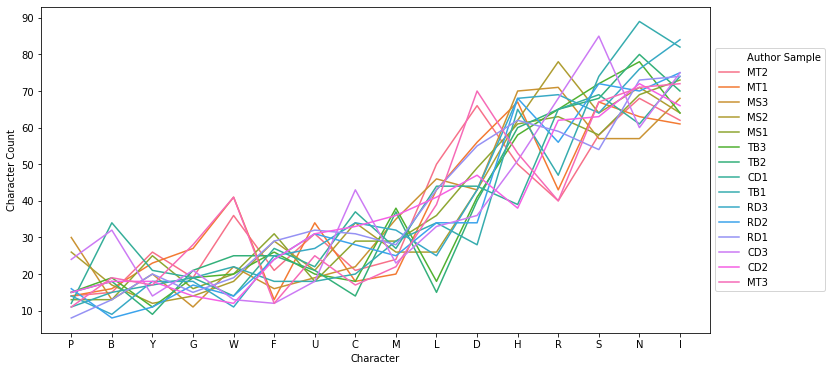

<IPython.core.display.Javascript object>

In [18]:
# Create a way to sort dataframe by letter appearance count
sorter = crosstab.sum().sort_values().reset_index()
sort_letters_dict = {k: v for k, v in zip(sorter["Character"], sorter.index)}

plot_df = crosstab.reset_index()
plot_df = pd.melt(plot_df, "Author Sample")
plot_df["order"] = plot_df["Character"].replace(sort_letters_dict)
plot_df = plot_df.sort_values("order")

# This is a hard plot to read..
# We can get some info, like MT2 & MT1 seem to have similar lines..
# There's gotta be a better way...*
# (*read with infomercial energy)
plt.figure(figsize=(12, 6))
sns.lineplot("Character", "value", hue="Author Sample", data=plot_df, sort=False)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.ylabel("Character Count")
plt.show()

## The process details

Part of our analysis is finding out what is expected for each cell in our table. Assuming there's no pattern, we would expect for each cell to be around the average for its 'group' (its group will be based on its row/column).  To find these expected values, we need the row averages, column averages and overall average.

```
cell_exp_val = row_mean * col_mean / table_mean
```

For example, below, we see the average for `CD1` is ~38.06, the average for `B` is ~17.26, and the table mean is ~37.48  So with our formula the expected value for the cell is:

```
38.06 * 17.26 / 37.48 = ~17.52
```

This might seem low given the numbers in the 30s.  The logic is that for `CD1` we're right around the table average, that is, Charles Darwin's writing isn't way above or below the average, so we wouldn't expect him to be way above or below the average number of `B`s; we would expect him to be right around the average number of `B`s (or just slightly above the average like we see here).  If you're not fully convinced, try working a couple more and reason out what's happening.

In [19]:
col_means = crosstab.mean(axis=0)
row_means = crosstab.mean(axis=1)
table_mean = crosstab.values.mean()
table_mean

37.475

<IPython.core.display.Javascript object>

In [20]:
col_means[[0]]

Character
B    17.266667
dtype: float64

<IPython.core.display.Javascript object>

In [21]:
row_means[[0]]

Author Sample
CD1    38.0625
dtype: float64

<IPython.core.display.Javascript object>

Find expected values for each cell.

In [22]:
expected_values = crosstab.copy()

for i, row_mean in enumerate(row_means):
    for j, col_mean in enumerate(col_means):
        expected_values.iloc[i, j] = row_mean * col_mean / table_mean

print("Sample of actuals")
display(crosstab.iloc[:2, :2])

print("Sample of expected values")
expected_values.iloc[:2, :2]

Sample of actuals


Character,B,C
Author Sample,,
CD1,34,37
CD2,18,33


Sample of expected values


Character,B,C
Author Sample,,
CD1,17.537358,27.017011
CD2,16.990216,26.174116


<IPython.core.display.Javascript object>

We then care about how much each cell is different than expected.  These differences are the focus of the analysis.  In the print outs above, we see that `CD1` and `CD2` had higher than expected values for `B` and `C`.  This is reflected in our residuals below.  If he had written less than expected we would see negative numbers in the residuals.

In [23]:
residuals = crosstab - expected_values
residuals.iloc[:2, :2]

Character,B,C
Author Sample,,
CD1,16.462642,9.982989
CD2,1.009784,6.825884


<IPython.core.display.Javascript object>

The rest of the process is finding a way to plot these residuals in a way that similar rows are plotted close together and that similiar columns are plotted close together.

To do this, we apply SVD* to a version of the residuals table and we use the first 2 outputted components as our x and y coordinates.  From this, like in PCA, we'll have an indication of how much variation is explained by each component.  So our plot's axes labels will typically have an indication of how much 'intertia' they explain.

We can repeat this plotting process for the columns, and do some additional processing to place them on the same plot as the rows for easier interpretation.

We'll let the `prince` package take it away from here.

*Singular Value Decomposition, for our purposes here, think of this as PCA

## Running Correspondance Analysis with `prince`

In [24]:
ca = prince.CA(n_components=5, random_state=42)
ca.fit(crosstab)

CA(benzecri=False, check_input=True, copy=True, engine='auto', n_components=5,
   n_iter=10, random_state=42)

<IPython.core.display.Javascript object>

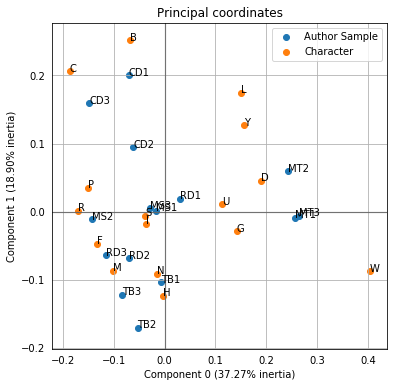

<IPython.core.display.Javascript object>

In [25]:
ca.plot_coordinates(crosstab)
plt.show()

### Interpreting the plot

This plot can be confusing to read.  A lot of misinterpretation can occur.  Double check your interpretation! Remember, we have a table showing us this information.  The main value of this plot is to try and uncover things we can easily overlook in the table, its not adding new information, but visualizing info we already have.  Double check your interpretation!

Interpretation guide:
* Start with interpreting just rows or just columns (in `prince` this means, start with just a single color)
* Rows plotted closer together are more similar in your contingency table
  * For example, `MT1` & `MT3` appear very similar in the plot
* Columns plotted closer together are more similar in your contingency table
  * For example, `S` & `I` appear very similar in the plot
* How close row points and column points are (in terms of euclidean distance) does not necesarily indicate that they are related/unrelated.
* You will use angles as a way to relate rows to columns (see below quote for explanation and example)

From the first resource linked above
> Possibly the simplest way to determine the relationship between a text sample and a character is to draw lines from their corresponding points in the plot to the origin. If the angle between the two lines is acute, then the character occurs more often in the sample than it does on average in the texts as a whole. Conversely, if the angle is obtuse, the character occurs less often than overall. The following draws the appropriate lines for our chosen text sample and characters; it appears the character “Y” occurs more often than average in “MT2”, while “P” occurs less often.

# Multiple Correspondance Analysis

In [26]:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/balloons/adult+stretch.data"
columns = ["Color", "Size", "Action", "Age", "Inflated"]

df = pd.read_csv(data_url, names=columns)
df.loc[df["Color"] == "YELLOW", "Age"] = "ADULT"
df.loc[df["Color"] == "PURPLE", "Age"] = "CHILD"
df.loc[0, "Age"] = "CHILD"
df.head()

,Color,Size,Action,Age,Inflated
0,YELLOW,SMALL,STRETCH,CHILD,T
1,YELLOW,SMALL,STRETCH,ADULT,T
2,YELLOW,SMALL,STRETCH,ADULT,F
3,YELLOW,SMALL,DIP,ADULT,F
4,YELLOW,SMALL,DIP,ADULT,F


<IPython.core.display.Javascript object>

Do some preliminary analysis, what do you expect to be related in our MCA?

Perform MCA and plot.

In [27]:
mca = prince.MCA(2)
mca.fit(df)

MCA(benzecri=False, check_input=True, copy=True, engine='auto', n_components=2,
    n_iter=10, random_state=None)

<IPython.core.display.Javascript object>

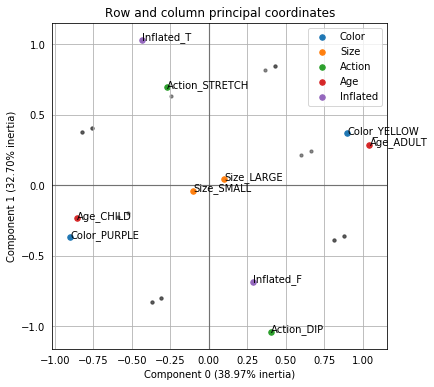

<IPython.core.display.Javascript object>

In [28]:
mca.plot_coordinates(df, show_column_labels=True)
plt.show()

Note, that we can recreate this output by one-hot encoding our DataFrame and running a Correspondance Analysis.  All we're missing is the coloring by each group.

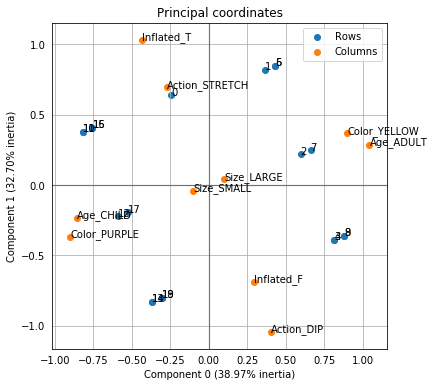

<IPython.core.display.Javascript object>

In [29]:
one_hot = pd.get_dummies(df)

ca = prince.CA(n_components=5, random_state=42)
ca.fit(one_hot)

ca.plot_coordinates(one_hot)
plt.show()

# Factor Analysis of Mixed Data

From good ole [Wikipedia](https://en.wikipedia.org/wiki/Factor_analysis_of_mixed_data):

> Roughly, we can say that FAMD works as a principal components analysis (PCA) for quantitative variables and as a multiple correspondence analysis (MCA) for qualitative variables.

In [30]:
# Churn dataset
data_url = "https://github.com/nchelaru/data-prep/raw/master/telco_cleaned_renamed.csv"
y_var = "Churn"

df = pd.read_csv(data_url)

# # Super smash bros dataset
# data_url = 'https://raw.githubusercontent.com/AdamSpannbauer/twitch_chat/master/data/slippi_data/generated_ssbm.csv'
# y_var = 'won'

# df = pd.read_csv(data_url).drop(columns=['index'])
# df["Character"] = df["gamerTag"].replace(
#     {
#         "S2J": "Captain Falcon",
#         "Hungrybox": "Jigglypuff",
#         "Leffen": "Fox",
#         "PewPewU": "Marth",
#         "Infinite Numbers": "Ice Climbers",
#         "Armada": "Peach",
#         "Lucky": "Fox",
#         "Westballz": "Falco",
#         "HugS": "Samus",
#         "Axe": "Pikachu",
#         "SFAT": "Fox",
#         "ChuDat": "Ice Climbers",
#         "Mang0": "Fox",
#         "Plup": "Sheik",
#         "Mew2King": "Sheik",
#         "Ice": "Fox",
#     }
# )

<IPython.core.display.Javascript object>

In [31]:
X = df.drop(columns=y_var)
y = df[y_var]
y.value_counts(normalize=True)

No Churn    0.734215
Churn       0.265785
Name: Churn, dtype: float64

<IPython.core.display.Javascript object>

In [32]:
# scale numeric data
num_X = X.select_dtypes("number")
cat_X = X.select_dtypes("O")

<IPython.core.display.Javascript object>

In [33]:
scaler = StandardScaler()
scaled = scaler.fit_transform(num_X)

scaled_df = pd.DataFrame(scaled, index=num_X.index, columns=num_X.columns)

scaled_X = pd.concat((scaled_df, cat_X), axis=1)
scaled_X.head()

,Tenure,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,-1.280248,-1.161694,-0.994194,Female,No SeniorCitizen,Partner,No Dependents,No PhoneService,No MultipleLines,DSL,No OnlineSecurity,OnlineBackup,No DeviceProtection,No TechSupport,No StreamingTV,No StreamingMovies,Month-to-month,PaperlessBilling,Electronic check
1,0.064303,-0.260878,-0.173740,Male,No SeniorCitizen,No Partner,No Dependents,PhoneService,No MultipleLines,DSL,OnlineSecurity,No OnlineBackup,DeviceProtection,No TechSupport,No StreamingTV,No StreamingMovies,One year,No PaperlessBilling,Mailed check
2,-1.239504,-0.363923,-0.959649,Male,No SeniorCitizen,No Partner,No Dependents,PhoneService,No MultipleLines,DSL,OnlineSecurity,OnlineBackup,No DeviceProtection,No TechSupport,No StreamingTV,No StreamingMovies,Month-to-month,PaperlessBilling,Mailed check
3,0.512486,-0.747850,-0.195248,Male,No SeniorCitizen,No Partner,No Dependents,No PhoneService,No MultipleLines,DSL,OnlineSecurity,No OnlineBackup,DeviceProtection,TechSupport,No StreamingTV,No StreamingMovies,One year,No PaperlessBilling,Bank transfer (automatic)
4,-1.239504,0.196178,-0.940457,Female,No SeniorCitizen,No Partner,No Dependents,PhoneService,No MultipleLines,Fiber optic,No OnlineSecurity,No OnlineBackup,No DeviceProtection,No TechSupport,No StreamingTV,No StreamingMovies,Month-to-month,PaperlessBilling,Electronic check


<IPython.core.display.Javascript object>

In [34]:
# perform famd on x
famd = prince.FAMD(n_components=2, random_state=42)
famd.fit(scaled_X)

FAMD(check_input=True, copy=True, engine='auto', n_components=2, n_iter=3,
     random_state=42)

<IPython.core.display.Javascript object>

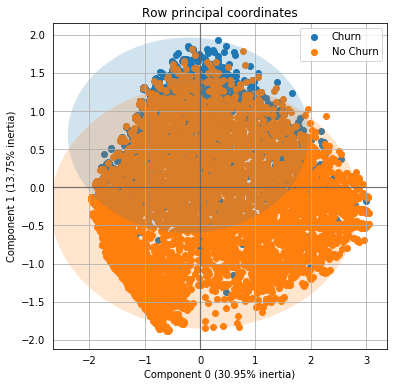

<IPython.core.display.Javascript object>

In [35]:
# plot row coordinates
famd.plot_row_coordinates(scaled_X, color_labels=y)
plt.show()

In [36]:
num_X = scaled_X.select_dtypes("number")
cat_X = scaled_X.select_dtypes("O")

<IPython.core.display.Javascript object>

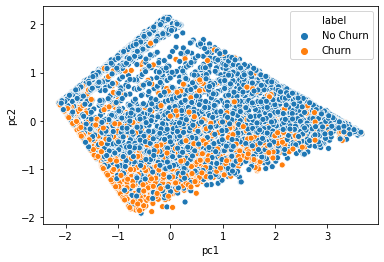

<IPython.core.display.Javascript object>

In [37]:
pca = PCA(2)
pcs = pca.fit_transform(num_X)

pc_df = pd.DataFrame(pcs, columns=["pc1", "pc2"])
pc_df["label"] = y

sns.scatterplot("pc1", "pc2", hue="label", data=pc_df)
plt.show()

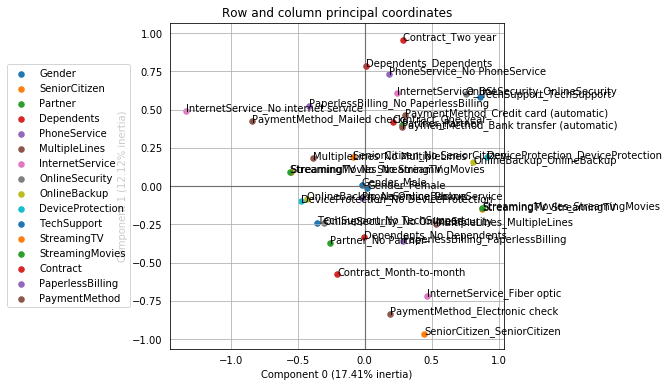

<IPython.core.display.Javascript object>

In [38]:
mca = prince.MCA(2)
mca.fit(cat_X)

mca.plot_coordinates(cat_X, show_column_labels=True, show_row_points=False)
plt.legend(loc="center left", bbox_to_anchor=(-0.5, 0.5))
plt.show()

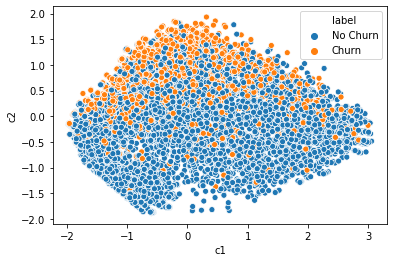

<IPython.core.display.Javascript object>

In [39]:
coords = famd.transform(scaled_X)
coords.columns = ["c1", "c2"]
coords["label"] = y

sns.scatterplot("c1", "c2", hue="label", data=coords)
plt.show()

In [40]:
coords = famd.transform(scaled_X)
y = y.replace({"Churn": 1, "No Churn": 0})

model = LogisticRegression()
model.fit(coords, y)
model.score(coords, y)

0.7943686006825939

<IPython.core.display.Javascript object>